In [1]:
 #%matplotlib inline
import numpy as np
import pickle
import os
#from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback
#from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [2]:
# encoder/decoder network size
batch_size=500
original_dim=26621 # number of movies
intermediate_dim=600
latent_dim=200
nb_epochs=20
epsilon_std=1.0

In [3]:
# encoder network
x=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='tanh')(x)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

In [4]:
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., std=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [5]:
# decoder network
h_decoder=Dense(intermediate_dim, activation='tanh')
x_bar=Dense(original_dim,activation='softmax') # this should be softmax right?
h_decoded = h_decoder(z)
x_decoded = x_bar(h_decoded)

In [6]:
# build and compile model
vae = Model(x, x_decoded)
def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [7]:
x_train = pickle.load( open( "train_data_0.file", "rb" ) )
#x_train = x_train[0:118000, :]
print("number of training users: ", x_train.shape[0])

x_val = pickle.load( open( "val_data_0.file", "rb" ) )
x_val = x_val.todense()

number of training users:  118493


In [9]:
def nn_batch_generator(x, y, batch_size, samples_per_epoch):
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    x =  x[shuffle_index, :]
    y =  y[shuffle_index, :]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        x_batch = x[index_batch,:].todense()
        y_batch = y[index_batch,:].todense()
        counter += 1
        yield (np.array(x_batch),np.array(y_batch))
        if (counter >= number_of_batches):
            counter=0

In [10]:
weightsPath = "./tmp/weights.hdf5"
checkpointer = ModelCheckpoint(filepath=weightsPath, verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

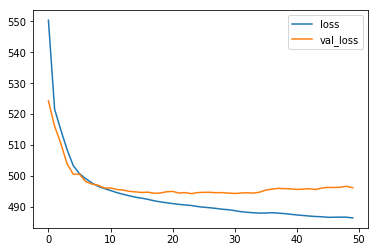

118000/118000 [==============================] - 88s - loss: 486.4370 - val_loss: 496.1855


In [11]:
vae.fit_generator(nn_batch_generator(x_train, x_train, batch_size, 118000), samples_per_epoch=118000, nb_epoch=nb_epochs, validation_data=(x_val, x_val), callbacks=[checkpointer, reduce_lr, plot_losses])